# HODL-SP24-Lec-7-Transformers



## Introduction



In the previous module we studied the use of NLP to classify text. We saw that bag of words and bigrams (with a bit of help from word embeddings) were very useful for this task. In this module we will focus on a different task for which we'll need to develop a different neural network architecture.


For this module we will use the ATIS dataset which includes queries from people trying to find travel information and book flight tickets between two destinations. The task will be to read this raw query and identify the key "entities" (or slots) in that query (which airports or cities, what days and times etc).

## Data Preprocessing



Let's begin extracting the data from the ATIS dataset and turning into a form that we can use in our Deep Learning models.

The ATIS dataset is a standard benchmark dataset widely used to build models for intent classification and slot filling tasks (we will explain all this shortly). You can find a very detailed explanation [here](https://catalog.ldc.upenn.edu/docs/LDC93S4B/corpus.html).

We will begin by loading the file and then partitioning into a test and a training set.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42)

In [ ]:
df_train = pd.read_csv('https://www.dropbox.com/s/3pjctskve34qef5/atis_train_data.csv?dl=1')
df_test = pd.read_csv('https://www.dropbox.com/s/pv7uc7ozvdxkncs/atis_test_data.csv?dl=1')

In [ ]:
df_train.head()

,Unnamed: 0,query,intent,slot filling
0,0,i want to fly from boston at 838 am and arriv...,flight,O O O O O B-fromloc.city_name O B-depart_time...
1,1,what flights are available from pittsburgh to...,flight,O O O O O B-fromloc.city_name O B-toloc.city_...
2,2,what is the arrival time in san francisco for...,flight_time,O O O B-flight_time I-flight_time O B-fromloc...
3,3,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-t...
4,4,round trip fares from pittsburgh to philadelp...,airfare,B-round_trip I-round_trip O O B-fromloc.city_...


Let's take a look at some queries and the corresponding slot-filling answers.

In [ ]:
pd.set_option('display.max_colwidth', None)

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df_train.intent.unique():
  df_small.loc[j] = df_train[df_train.intent==i].iloc[0]
  j = j+1

In [ ]:
df_small

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


In [ ]:
df_small[['query', 'slot filling']]

,query,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,O O O O O O O O B-city_name
5,what 's the airport at orlando,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,O O O O B-transport_type O O O B-city_name


In [ ]:
query_data_train = df_train['query'].values
slot_data_train = df_train['slot filling'].values

query_data_test = df_test['query'].values
slot_data_test = df_test['slot filling'].values

## Transformers





### Encoder Model



Because the code for transformer encoder architecture is a bit complicated to write, we have decided to package it. This means that you can import it directly from our own "library" (in the same way you do it for Keras layers).


In [ ]:
# Download the "HODL" library
!wget -q 'https://www.dropbox.com/s/4rdgil1epnvgitf/HODL.py'

In [ ]:
# Import the transformer encoder and the positional embedding
from HODL import TransformerEncoder, PositionalEmbedding

In [ ]:
max_query_length = 30

In [ ]:
# Textvec of query

# define text_vectorization layer
text_vectorization_query = keras.layers.TextVectorization(
    output_sequence_length=max_query_length
)

# run training corpus through layer to create vocab
text_vectorization_query.adapt(query_data_train)
query_vocab_size = text_vectorization_query.vocabulary_size()

In [ ]:
text_vectorization_query.vocabulary_size()

888

In [ ]:
text_vectorization_query.get_vocabulary()[:20]

['',
 '[UNK]',
 'to',
 'from',
 'flights',
 'the',
 'on',
 'what',
 'me',
 'flight',
 'boston',
 'show',
 'san',
 'i',
 'denver',
 'a',
 'francisco',
 'in',
 'and',
 'atlanta']

In [ ]:
# vectorize train and test queries
source_train = text_vectorization_query(query_data_train)
source_test = text_vectorization_query(query_data_test)

Next, we need to do STIE for the output side of the problem i.e. the slots

Let's take another look at the slots.

In [ ]:
df_small['slot filling'].head()

0     O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day 
1          O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name 
2                                                                                            B-cost_relative O O B-fromloc.city_name O B-toloc.city_name 
3                                                                                            O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name 
4                                                                                                                            O O O O O O O O B-city_name 
Name: slot filling, dtype: object

Note the - and . in the entity names 👆. We don't want the standardization to strip those out. Nor do we want to lower-case the names.

In [ ]:
# Textvec of slots
text_vectorization_slots = keras.layers.TextVectorization(
    output_sequence_length=max_query_length,
    standardize=None
)
text_vectorization_slots.adapt(slot_data_train)
slot_vocab_size = text_vectorization_slots.vocabulary_size()

target_train = text_vectorization_slots(slot_data_train)
target_test = text_vectorization_slots(slot_data_test)


In [ ]:
text_vectorization_slots.get_vocabulary()

In [ ]:
text_vectorization_slots.vocabulary_size()

125

We will now set up a DNN with a Transformer Encoder (as described in lecture - see picture below).

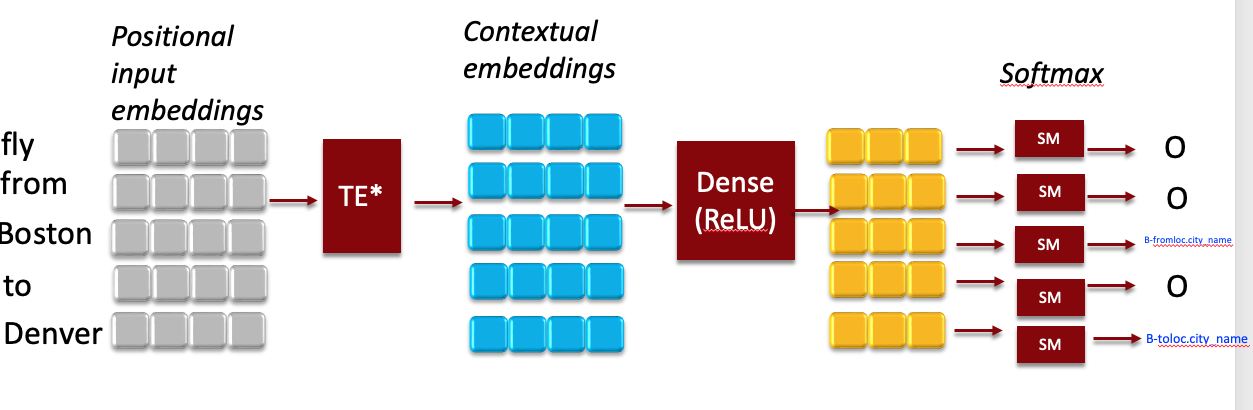

In [ ]:
# Params
embed_dim = 512
dense_dim = 64
num_heads = 5

units = 128

# Embedding and Masking
inputs = keras.Input(shape=(max_query_length,))

embedding = PositionalEmbedding(max_query_length,
                                query_vocab_size,
                                embed_dim)
x = embedding(inputs) #grey vectors

encoder_out = TransformerEncoder(embed_dim,
                                 dense_dim,
                                 num_heads)(x)

#encoder_out = BLUE!!! vectors

# Classifier
x = keras.layers.Dense(units, activation='relu')(encoder_out)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(slot_vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 positional_embedding (Posi  (None, 30, 512)           470016    
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, 30, 512)           5319232   
 formerEncoder)                                                  
                                                                 
 dense_2 (Dense)             (None, 30, 128)           65664     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 dense_3 (Dense)             (None, 30, 125)           16125 

**OPTIONAL**: We have "hand calculated" the number of parameters in the Transformer Encoder. **After the next class**, work through it and understand it line-by-line for fame and fortune 🚀 🏅!!

In [ ]:
(num_heads * ((embed_dim + 1) * embed_dim * 3) +   # self-attention heads
(num_heads * embed_dim + 1) * embed_dim +          # concatenate-and-project
embed_dim * 2 +                                    # first layer norm
(embed_dim + 1) * dense_dim +                      # first feed-forward
(dense_dim + 1) * (embed_dim) +                    # final feed-forward
 embed_dim * 2)                                    # final layer norm

5319232

BTW, you can peek into any layer's weights easily using its `weights` attribute.

Let's say we want to check out the weights of the `PositionalEmbedding` layer in the model above.

In [ ]:
embedding.weights

[<tf.Variable 'positional_embedding/embedding/embeddings:0' shape=(888, 512) dtype=float32, numpy=
 array([[ 0.03581891,  0.01626286, -0.01412892, ...,  0.0452905 ,
         -0.02311034,  0.02508745],
        [ 0.02021731,  0.01918722, -0.00385682, ...,  0.02363205,
         -0.02280219, -0.00295401],
        [-0.01289467,  0.03753278, -0.00539821, ...,  0.02464176,
         -0.01119621,  0.01759655],
        ...,
        [ 0.02409312, -0.00869781, -0.01521801, ...,  0.00323968,
          0.01492134, -0.01377813],
        [ 0.04109884,  0.0002197 ,  0.01844469, ..., -0.04935136,
         -0.02678368, -0.01112056],
        [-0.00839518, -0.02063971,  0.00734846, ...,  0.01073778,
          0.00010662,  0.02275636]], dtype=float32)>,
 <tf.Variable 'positional_embedding/embedding_1/embeddings:0' shape=(30, 512) dtype=float32, numpy=
 array([[ 0.04791559, -0.00179821,  0.02660979, ...,  0.02429681,
         -0.02299124, -0.01301686],
        [-0.0365486 , -0.01160147, -0.04650236, ..., -0.

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])


In [ ]:
BATCH_SIZE = 64
epochs = 10

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/10
78/78 [==============================] - 11s 66ms/step - loss: 0.4511 - sparse_categorical_accuracy: 0.9048
Epoch 2/10
78/78 [==============================] - 3s 32ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9612
Epoch 3/10
78/78 [==============================] - 3s 34ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9704
Epoch 4/10
78/78 [==============================] - 2s 28ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9797
Epoch 5/10
78/78 [==============================] - 2s 29ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9862
Epoch 6/10
78/78 [==============================] - 2s 31ms/step - loss: 0.0357 - sparse_categorical_accuracy: 0.9900
Epoch 7/10
78/78 [==============================] - 2s 30ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9921
Epoch 8/10
78/78 [==============================] - 2s 28ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9936
Epoch 9/10
78/78 [==============================] - 2s 

The accuracy on the training set is 99.55%! What is it on the test set?

In [ ]:
model.evaluate(source_test, target_test)

28/28 [==============================] - 1s 10ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9887


[0.06391596049070358, 0.9886524677276611]

Is this impressive?

<br>
<br>
<br>
<br>

Let's write a little helper function to calculate the accuracy on just the non-O slots.

In [ ]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0) #+ np.not_equal(predicted, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  weights = np.ones(sample_length)

  return np.dot(correct_predictions, weights) / sample_length


In [ ]:
predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

28/28 [==============================] - 1s 9ms/step
Accuracy = 0.967
Accuracy on slots = 0.920


We get 92% accuracy on the slots and 97% accuracy in general.




---

Is 92% accuracy good enough for practical use?




---



### Examples

Let's see some examples:

In [ ]:
def predict_slots_query(query):
  sentence = text_vectorization_query([query])

  prediction = np.argmax(model.predict(sentence), axis=-1)[0]

  inverse_vocab = dict(enumerate(text_vectorization_slots.get_vocabulary()))
  decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
  return decoded_prediction

In [ ]:
examples = [
            'from los angeles',
            'to los angeles',
            'cheapest flight from boston to los angeles tomorrow',
            'what is the airport at orlando',
            'what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars',
            'flight from boston to santiago',
]

for e in examples:
  print(e)
  print(predict_slots_query(e))
  print()

from los angeles
1/1 [==============================] - 0s 21ms/step
O B-fromloc.city_name I-fromloc.city_name                           

to los angeles
1/1 [==============================] - 0s 19ms/step
O B-toloc.city_name I-toloc.city_name                           

cheapest flight from boston to los angeles tomorrow
1/1 [==============================] - 0s 19ms/step
B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative                      

what is the airport at orlando
1/1 [==============================] - 0s 19ms/step
O O O O O B-airport_name                        

what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars
1/1 [==============================] - 0s 19ms/step
O O O O O O O O B-fromloc.city_name O B-toloc.city_name O O O O B-fare_amount I-fare_amount             

flight from boston to santiago
1/1 [==============================] - 0s 19ms/step
O O B-fromloc.city_na

In [ ]:
predict_slots_query("Your query here!")


Can we "break" this model with an "adversarial" query?

In [ ]:
predict_slots_query("cheapest flight to fly from MIT to Mars")

1/1 [==============================] - 0s 19ms/step


'B-cost_relative O O O O O O O                      '